In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from metal.contrib.slicing.synthetics.geometric_synthetics import *

In [2]:
k = 2
m = 30
n = 5000

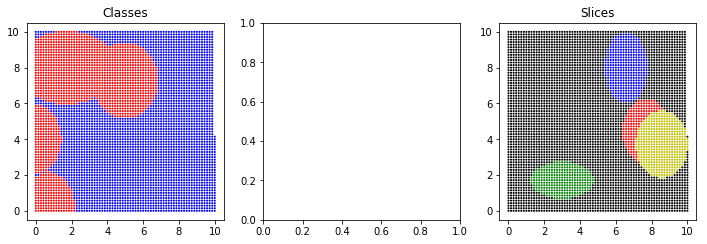

In [3]:
L, X, Y, Z = generate_dataset(k, m, n)

### Analyze Data

In [4]:
from scipy.sparse import csr_matrix
import torch

L = csr_matrix(L)
X = torch.Tensor(X)

In [5]:
from metal.utils import split_data

Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.8, 0.1, 0.1], shuffle=True, seed=123)

In [6]:
from metal.analysis import lf_summary

lf_summary(Ls[1], Ys[1])

,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
0,"[1, 2]",0.032,0.032,0.028,12,4,0.750000
1,"[1, 2]",0.062,0.062,0.062,16,15,0.516129
2,"[1, 2]",0.280,0.280,0.236,81,59,0.578571
3,"[1, 2]",0.186,0.184,0.162,52,41,0.559140
4,"[1, 2]",0.120,0.118,0.098,40,20,0.666667
5,"[1, 2]",0.220,0.220,0.176,77,33,0.700000
6,"[1, 2]",0.078,0.078,0.066,23,16,0.589744
7,"[1, 2]",0.130,0.130,0.112,57,8,0.876923
8,"[1, 2]",0.314,0.300,0.256,111,46,0.707006
9,"[1, 2]",0.138,0.138,0.130,59,10,0.855072


In [7]:
# num_votes = Ls[0].sum(axis=1)
# plt.hist(num_votes)

In [8]:
# np.save('synthetic_data.npy', (L, Y))

# Learn

In [9]:
# L, Y = np.load('synthetic_data.npy')

### Snorkel LabelModel

In [10]:
from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel

label_model = SnorkelLabelModel()
label_model.train_model(Ls[0])

Inferred cardinality: 2


In [11]:
from metal.metrics import accuracy_score

Y_train_ps = label_model.predict_proba(Ls[0])
Y_train_p = label_model.predict(Ls[0])

Y_dev_ps = label_model.predict_proba(Ls[0])
Y_dev_p = label_model.predict(Ls[1])
accuracy_score(Ys[1], Y_dev_p)

0.762

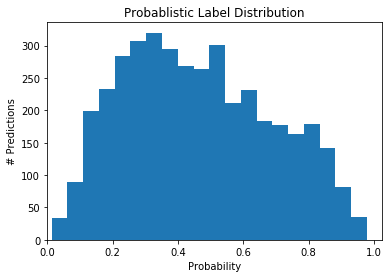

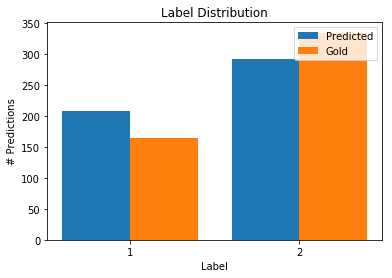

In [12]:
from metal.contrib.visualization.analysis import (
    plot_predictions_histogram, 
    plot_probabilities_histogram,
)
    
plot_probabilities_histogram(Y_dev_ps[:,0], title="Probablistic Label Distribution")
plot_predictions_histogram(Y_dev_p, Ys[1], title="Label Distribution")

## Compare Baselines

In [13]:
from metal.contrib.slicing.online_dp import SliceHatModel, MLPModule
from metal.end_model import EndModel

model_configs = {
    "EndModel": {
        "base_model_class" : EndModel,
        "base_model_init_kwargs": {
            "layer_out_dims": [5, 2],
            "input_layer_config": {
                "input_relu": False,
                "input_batchnorm": False,
                "input_dropout": 0.0,
            },
            "input_module": MLPModule(**{
                'input_dim': 2,
                'middle_dims': [5],
                'bias': True,
                'output_dim': 5
            })
        },
        
        "train_on_L": False,
        "L_weights": None
    },
    "Upweighted 2x": {
        "base_model_class" : EndModel,
        "base_model_init_kwargs": {
            "layer_out_dims": [5, 2],
            "input_layer_config": {
                "input_relu": False,
                "input_batchnorm": False,
                "input_dropout": 0.0,
            },
            "input_module": MLPModule(**{
                'input_dim': 2,
                'middle_dims': [5],
                'bias': True,
                'output_dim': 5
            })
        },
        "train_on_L": False,
        "L_weights": [2, 1, 1]
    },
    "MixtureOfExperts": {
        "base_model_class" : EndModel,
        "base_model_init_kwargs": {
            "layer_out_dims": [5, 2],
            "input_layer_config": {
                "input_relu": False,
                "input_batchnorm": False,
                "input_dropout": 0.0,
            },
            "input_module": MLPModule(**{
                'input_dim': 2,
                'middle_dims': [5],
                'bias': True,
                'output_dim': 5
            })
        },
        "train_on_L": False,
        "mixture_of_experts": True,
        "L_weights": None
    },
    "AttentionModel": {
        "base_model_class" : SliceHatModel,
        "base_model_init_kwargs": {
            'm': 2,
            'slice_weight': 0.1,
            'reweight': True,
            'base_model': EndModel([2, 10, 10, 2])
        },
        "train_on_L": True,
        "L_weights": None
    }
}


Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=10, out_features=2, bias=True)
)



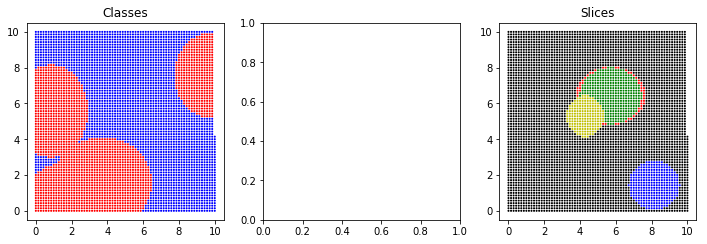

---------- Training EndModel ----------
Inferred cardinality: 2

Network architecture:
Sequential(
  (0): MLPModule(
    (input_layer): Sequential(
      (0): Linear(in_features=2, out_features=5, bias=True)
      (1): ReLU()
      (2): Linear(in_features=5, out_features=5, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=5, out_features=2, bias=True)
)

Saving model at iteration 0 with best score 0.828
[E:0]	Train Loss: 0.676	Dev accuracy: 0.828
[E:1]	Train Loss: 0.667	Dev accuracy: 0.824
Saving model at iteration 2 with best score 0.836
[E:2]	Train Loss: 0.666	Dev accuracy: 0.836
Saving model at iteration 3 with best score 0.852
[E:3]	Train Loss: 0.666	Dev accuracy: 0.852
[E:4]	Train Loss: 0.666	Dev accuracy: 0.828
[E:5]	Train Loss: 0.665	Dev accuracy: 0.842
[E:6]	Train Loss: 0.665	Dev accuracy: 0.832
[E:7]	Train Loss: 0.665	Dev accuracy: 0.832
[E:8]	Train Loss: 0.665	Dev accuracy: 0.840
[E:9]	Train Loss: 0.665	Dev accuracy: 0.842
Saving model at iteration 10 with bes

[E:5]	Train Loss: 0.659	Dev accuracy: 0.870
Saving model at iteration 6 with best score 0.888
[E:6]	Train Loss: 0.659	Dev accuracy: 0.888
[E:7]	Train Loss: 0.659	Dev accuracy: 0.874
[E:8]	Train Loss: 0.659	Dev accuracy: 0.886
Saving model at iteration 9 with best score 0.900
[E:9]	Train Loss: 0.659	Dev accuracy: 0.900
Restoring best model from iteration 9 with score 0.900
Finished Training
Accuracy: 0.900
        y=1    y=2   
 l=1    192    20    
 l=2    30     258   
Accuracy: 0.900
        y=1    y=2   
 l=1    192    20    
 l=2    30     258   
Dev Score on L1 examples: 0.9
----------Training slice_2_expert----------

Network architecture:
Sequential(
  (0): MLPModule(
    (input_layer): Sequential(
      (0): Linear(in_features=2, out_features=5, bias=True)
      (1): ReLU()
      (2): Linear(in_features=5, out_features=5, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=5, out_features=2, bias=True)
)

Saving model at iteration 0 with best score 0.860
[E:0]	Trai

Saving model at iteration 0 with best score 0.886
[E:0]	Train Loss: 0.672	Dev accuracy: 0.886
[E:1]	Train Loss: 0.661	Dev accuracy: 0.886
[E:2]	Train Loss: 0.661	Dev accuracy: 0.854
[E:3]	Train Loss: 0.661	Dev accuracy: 0.884
[E:4]	Train Loss: 0.662	Dev accuracy: 0.874
[E:5]	Train Loss: 0.661	Dev accuracy: 0.880
Saving model at iteration 6 with best score 0.900
[E:6]	Train Loss: 0.661	Dev accuracy: 0.900
[E:7]	Train Loss: 0.661	Dev accuracy: 0.868
[E:8]	Train Loss: 0.661	Dev accuracy: 0.890
[E:9]	Train Loss: 0.661	Dev accuracy: 0.878
Restoring best model from iteration 6 with score 0.900
Finished Training
Accuracy: 0.900
        y=1    y=2   
 l=1    202    30    
 l=2    20     248   
Accuracy: 0.900
        y=1    y=2   
 l=1    202    30    
 l=2    20     248   
Dev Score on L8 examples: 0.9
----------Training slice_9_expert----------

Network architecture:
Sequential(
  (0): MLPModule(
    (input_layer): Sequential(
      (0): Linear(in_features=2, out_features=5, bias=True)
     

Saving model at iteration 0 with best score 0.904
[E:0]	Train Loss: 0.667	Dev accuracy: 0.904
Saving model at iteration 1 with best score 0.908
[E:1]	Train Loss: 0.661	Dev accuracy: 0.908
[E:2]	Train Loss: 0.661	Dev accuracy: 0.906
Saving model at iteration 3 with best score 0.912
[E:3]	Train Loss: 0.660	Dev accuracy: 0.912
[E:4]	Train Loss: 0.660	Dev accuracy: 0.910
[E:5]	Train Loss: 0.660	Dev accuracy: 0.846
[E:6]	Train Loss: 0.661	Dev accuracy: 0.872
[E:7]	Train Loss: 0.660	Dev accuracy: 0.890
[E:8]	Train Loss: 0.660	Dev accuracy: 0.904
[E:9]	Train Loss: 0.660	Dev accuracy: 0.896
Restoring best model from iteration 3 with score 0.912
Finished Training
Accuracy: 0.912
        y=1    y=2   
 l=1    197    19    
 l=2    25     259   
Accuracy: 0.912
        y=1    y=2   
 l=1    197    19    
 l=2    25     259   
Dev Score on L15 examples: 0.912
----------Training slice_16_expert----------

Network architecture:
Sequential(
  (0): MLPModule(
    (input_layer): Sequential(
      (0): 

Saving model at iteration 0 with best score 0.870
[E:0]	Train Loss: 0.661	Dev accuracy: 0.870
[E:1]	Train Loss: 0.660	Dev accuracy: 0.852
Saving model at iteration 2 with best score 0.890
[E:2]	Train Loss: 0.661	Dev accuracy: 0.890
[E:3]	Train Loss: 0.661	Dev accuracy: 0.848
[E:4]	Train Loss: 0.660	Dev accuracy: 0.878
[E:5]	Train Loss: 0.660	Dev accuracy: 0.858
Saving model at iteration 6 with best score 0.898
[E:6]	Train Loss: 0.661	Dev accuracy: 0.898
Saving model at iteration 7 with best score 0.902
[E:7]	Train Loss: 0.660	Dev accuracy: 0.902
[E:8]	Train Loss: 0.660	Dev accuracy: 0.896
[E:9]	Train Loss: 0.660	Dev accuracy: 0.870
Restoring best model from iteration 7 with score 0.902
Finished Training
Accuracy: 0.902
        y=1    y=2   
 l=1    199    26    
 l=2    23     252   
Accuracy: 0.902
        y=1    y=2   
 l=1    199    26    
 l=2    23     252   
Dev Score on L22 examples: 0.902
----------Training slice_23_expert----------

Network architecture:
Sequential(
  (0): MLP

Accuracy: 0.884
        y=1    y=2   
 l=1    185    21    
 l=2    37     257   
Accuracy: 0.884
        y=1    y=2   
 l=1    185    21    
 l=2    37     257   
Dev Score on L28 examples: 0.884
----------Training slice_29_expert----------

Network architecture:
Sequential(
  (0): MLPModule(
    (input_layer): Sequential(
      (0): Linear(in_features=2, out_features=5, bias=True)
      (1): ReLU()
      (2): Linear(in_features=5, out_features=5, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=5, out_features=2, bias=True)
)

Saving model at iteration 0 with best score 0.840
[E:0]	Train Loss: 0.670	Dev accuracy: 0.840
[E:1]	Train Loss: 0.664	Dev accuracy: 0.840
Saving model at iteration 2 with best score 0.876
[E:2]	Train Loss: 0.663	Dev accuracy: 0.876
[E:3]	Train Loss: 0.663	Dev accuracy: 0.822
[E:4]	Train Loss: 0.663	Dev accuracy: 0.828
[E:5]	Train Loss: 0.664	Dev accuracy: 0.858
[E:6]	Train Loss: 0.663	Dev accuracy: 0.840
Saving model at iteration 7 with best sco

/dfs/scratch0/vschen/snorkel-pytorch/venv/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Saving model at iteration 0 with best score 0.858
[E:0]	Train Loss: 21.254	Dev accuracy: 0.858


/dfs/scratch0/vschen/metal/metal/contrib/slicing/mixture_of_experts.py:136: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.weighted_experts(X)).detach().numpy()


Saving model at iteration 1 with best score 0.876
[E:1]	Train Loss: 21.170	Dev accuracy: 0.876
[E:2]	Train Loss: 21.158	Dev accuracy: 0.866
[E:3]	Train Loss: 21.161	Dev accuracy: 0.844
[E:4]	Train Loss: 21.147	Dev accuracy: 0.850
[E:5]	Train Loss: 21.140	Dev accuracy: 0.840
[E:6]	Train Loss: 21.142	Dev accuracy: 0.844
[E:7]	Train Loss: 21.134	Dev accuracy: 0.850
[E:8]	Train Loss: 21.135	Dev accuracy: 0.850
[E:9]	Train Loss: 21.123	Dev accuracy: 0.854
[E:10]	Train Loss: 21.113	Dev accuracy: 0.856
[E:11]	Train Loss: 21.128	Dev accuracy: 0.856
[E:12]	Train Loss: 21.124	Dev accuracy: 0.848
[E:13]	Train Loss: 21.108	Dev accuracy: 0.870
[E:14]	Train Loss: 21.098	Dev accuracy: 0.858
[E:15]	Train Loss: 21.094	Dev accuracy: 0.872
Saving model at iteration 16 with best score 0.882
[E:16]	Train Loss: 21.097	Dev accuracy: 0.882
[E:17]	Train Loss: 21.078	Dev accuracy: 0.870
[E:18]	Train Loss: 21.066	Dev accuracy: 0.874
[E:19]	Train Loss: 21.064	Dev accuracy: 0.868
[E:20]	Train Loss: 21.063	Dev accu

/dfs/scratch0/vschen/snorkel-pytorch/venv/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Saving model at iteration 1 with best score 0.804
[E:1]	Train Loss: 0.609	Dev accuracy: 0.804
[E:2]	Train Loss: 0.607	Dev accuracy: 0.800
Saving model at iteration 3 with best score 0.840
[E:3]	Train Loss: 0.604	Dev accuracy: 0.840
Saving model at iteration 4 with best score 0.842
[E:4]	Train Loss: 0.603	Dev accuracy: 0.842
[E:5]	Train Loss: 0.602	Dev accuracy: 0.838
[E:6]	Train Loss: 0.602	Dev accuracy: 0.832
[E:7]	Train Loss: 0.601	Dev accuracy: 0.840
[E:8]	Train Loss: 0.601	Dev accuracy: 0.840
[E:9]	Train Loss: 0.601	Dev accuracy: 0.842
[E:10]	Train Loss: 0.601	Dev accuracy: 0.824
[E:11]	Train Loss: 0.600	Dev accuracy: 0.826
[E:12]	Train Loss: 0.600	Dev accuracy: 0.838
[E:13]	Train Loss: 0.600	Dev accuracy: 0.842
Saving model at iteration 14 with best score 0.852
[E:14]	Train Loss: 0.600	Dev accuracy: 0.852
Saving model at iteration 15 with best score 0.856
[E:15]	Train Loss: 0.599	Dev accuracy: 0.856
Saving model at iteration 16 with best score 0.866
[E:16]	Train Loss: 0.599	Dev ac

In [15]:
from simulate import train_models

L, X, Y, Z, targeting_lfs_idx = generate_dataset(k, m, n, return_targeting_lfs=True)
plt.show()
Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.8, 0.1, 0.1], shuffle=True)

L_weights = np.ones(m)
L_weights[targeting_lfs_idx] = 2
L_weights = list(L_weights)
model_configs['Upweighted 2x']['L_weights'] = L_weights

train_kwargs = {
    'print_every': 1,
    'l2': 0,
    'lr': 0.01,
    'n_epochs': 50,
    'batch_size': 32,
    'disable_prog_bar': True,
}

trained_models = train_models(
    (Xs[0], Xs[1]),
    (np.array(Ls[0].todense()).astype(np.float32), np.array(Ls[1].todense()).astype(np.float32)),
    Ys[1],
    model_configs,
    train_kwargs,
    verbose=True
)

In [16]:
from torch.utils.data import DataLoader
from metal.utils import SlicingDataset
from metal.contrib.slicing.utils import evaluate_slicing

eval_loader = DataLoader(SlicingDataset(Xs[1], Ys[1], Zs[1]))

results = {}
for model_name, model in trained_models.items():
    scores = evaluate_slicing(model, eval_loader, verbose=False)
    results[model_name] = {k:v['accuracy'] for k,v in scores.items()}
    
import pandas as pd
pd.DataFrame.from_dict(results)

100%|██████████| 500/500 [00:00<00:00, 11317.85it/s]


SUMMARY (accuracies):
All: 0.862
Slice 0: 0.8401937046004843
Slice 1: 1.0
Slice 2: 1.0
Slice 3: 1.0
Slice 4: 0.8235294117647058



100%|██████████| 500/500 [00:00<00:00, 12304.27it/s]


SUMMARY (accuracies):
All: 0.764
Slice 0: 0.7142857142857143
Slice 1: 1.0
Slice 2: 1.0
Slice 3: 1.0
Slice 4: 1.0



100%|██████████| 500/500 [00:00<00:00, 10787.76it/s]


SUMMARY (accuracies):
All: 0.898
Slice 0: 0.8765133171912833
Slice 1: 1.0
Slice 2: 1.0
Slice 3: 1.0
Slice 4: 1.0



SUMMARY (accuracies):
All: 0.926
Slice 0: 0.910411622276029
Slice 1: 1.0
Slice 2: 1.0
Slice 3: 1.0
Slice 4: 1.0


,EndModel,Upweighted 2x,MixtureOfExperts,AttentionModel
all,0.862000,0.764000,0.898000,0.926000
slice_0,0.840194,0.714286,0.876513,0.910412
slice_1,1.000000,1.000000,1.000000,1.000000
slice_2,1.000000,1.000000,1.000000,1.000000
slice_3,1.000000,1.000000,1.000000,1.000000
slice_4,0.823529,1.000000,1.000000,1.000000


In [ ]:
assert False

### EndModel

In [ ]:
from torch.utils.data import DataLoader
from metal.utils import SlicingDataset

train_loader = DataLoader(
    SlicingDataset(Xs[0], Y_train_ps),
    batch_size=256,
    shuffle=True
)

In [ ]:
from metal.end_model import EndModel
import torch

end_model = EndModel([2,10,10,2])
end_model.train_model(train_loader, dev_data=(Xs[1], Ys[1]), l2=0.0, 
                      n_epochs=25, print_every=5, validation_metric='accuracy', 
                      disable_prog_bar=True)
end_model.score((Xs[1], Ys[1]))

### SliceModel

In [ ]:
from torch.utils.data import DataLoader
from metal.utils import SlicingDataset

Ls_tensors = [torch.Tensor(np.asarray(L.todense())) for L in Ls]

train_loader = DataLoader(
    SlicingDataset(Xs[0], Ls_tensors[0], Y_train_ps),
    batch_size=256,
    shuffle=True
)

dev_loader = DataLoader(
    SlicingDataset(Xs[1], Ys[1]),
    batch_size=256,
)

In [ ]:
import torch.nn as nn
from metal.contrib.slicing.online_dp import SliceDPModel, MLPModule

n, m = Ls[0].shape
input_dim = Xs[0].shape[1]

input_module = MLPModule(input_dim, 10, [10], bias=True)
slice_model = SliceDPModel(input_module, r=10, m=m, reweight=False, slice_weight=0.1, 
                           verbose=False)
slice_model.train_model(
    train_loader,
    dev_data=dev_loader,
    l2=0.0, n_epochs=50,
    print_every=5, validation_metric='accuracy',
    log_writer=None,
    verbose=True, 
    use_cuda=False,
    disable_prog_bar=True,
)

### New SliceModel

In [ ]:
from metal.contrib.slicing.online_dp import SliceHatModel

# base_model = EndModel([2,20,20,2], verbose=False)
slicer = SliceHatModel(end_model, m, slice_weight=0.1)

slicer.train_model(
    train_loader,
    dev_data=dev_loader,
    lr=0.05,
    l2=0.0, n_epochs=50,
    print_every=5, validation_metric='accuracy',
    log_writer=None,
    verbose=True, 
    use_cuda=False,
    disable_prog_bar=True,
)

In [ ]:
from metal.contrib.slicing.utils import evaluate_slicing

from torch.utils.data import DataLoader
from metal.utils import SlicingDataset

eval_loader = DataLoader(SlicingDataset(Xs[1], Ys[1], Zs[1]))

_ = evaluate_slicing(end_model, eval_loader, verbose=False)
_ = evaluate_slicing(slice_model, eval_loader, verbose=False)
_ = evaluate_slicing(slicer, eval_loader, verbose=False)

In [ ]:
# L_pred = np.round(slicer.predict_L_proba(Xs[1]).numpy())
# L_pred[L_pred == 0] = 2
# accuracy_score(Ls[1].reshape(-1,1), L_pred.reshape(-1,1), ignore_in_gold=[0])

In [ ]:
# ((Ls[1] == L_pred).sum(axis=0)/(Ls[1] != 0).sum(axis=0)).mean()

### Repeated Trials

In [ ]:
# Grid search as necessary first


In [ ]:
from metal.utils import split_data, SlicingDataset
from metal.label_model.baselines import MajorityLabelVoter
from metal.end_model import EndModel
from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel
from metal.contrib.slicing.synthetics.geometric_synthetics import *
from metal.contrib.slicing.online_dp import SliceHatModel
from metal.contrib.slicing.utils import evaluate_slicing

import torch
from torch.utils.data import DataLoader

NUM_TRIALS = 3
SPLIT = 2

k = 2
m = 30
n = 5000

batchsize = 32
layer_output_dims = [2, 10, 10, 2]
slice_weight = 0.1

summary = {}
for model in ['mv', 'dp', 'up', 'me', 'sm']:
    summary[model] = {
        'overall': [],
        'slices': []
    }

for i in range(NUM_TRIALS):
    L, X, Y, Z = generate_dataset(k, m, n, plotting=True)
    Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.8, 0.1, 0.1], shuffle=True)
    
    lm = SnorkelLabelModel()
    lm.train_model(Ls[0])
    Y_train_ps = lm.predict_proba(Ls[0])

    dev_loader = DataLoader(
        SlicingDataset(Xs[1], Ys[1]),
        batch_size=256,
    )
    eval_loader = DataLoader(SlicingDataset(Xs[2], Ys[2], Zs[2]))
    
    # Train dp
    em_train_loader = DataLoader(
        SlicingDataset(Xs[0], Y_train_ps),
        batch_size=batchsize,
        shuffle=True
    )    
    
    dp = EndModel(layer_output_dims)
    dp.train_model(
        em_train_loader,
        dev_data=dev_loader,
        lr=0.05,
        l2=0.0, 
        n_epochs=50,
        print_every=5, 
        validation_metric='accuracy',
        verbose=True, 
        use_cuda=False,
        disable_prog_bar=True,
    )

    dp_results = evaluate_slicing(dp, eval_loader, verbose=False)
    summary['dp']['overall'].append(dp_results['all']['accuracy'])
    for s in range(1,5):
        summary['dp']['slices'].append(dp_results[f'slice_{s}']['accuracy'])    
    
    # Train dp_sm
    L_train = torch.Tensor(np.asarray(Ls[0].todense()))    
    sm_train_loader = DataLoader(
        SlicingDataset(Xs[0], L_train, Y_train_ps),
        batch_size=batchsize,
        shuffle=True
    )
    
    dp = EndModel(layer_output_dims) # Fresh copy to be safe
    sm = SliceHatModel(dp, m, slice_weight=slice_weight)
    sm.train_model(
        sm_train_loader,
        dev_data=dev_loader,
        lr=0.05,
        l2=0.0, 
        n_epochs=50,
        print_every=5, 
        validation_metric='accuracy',
        verbose=True, 
        use_cuda=False,
        disable_prog_bar=True,
    )
    
    sm_results = evaluate_slicing(sm, eval_loader, verbose=False)
    summary['sm']['overall'].append(sm_results['all']['accuracy'])
    for s in range(1,5):
        summary['sm']['slices'].append(sm_results[f'slice_{s}']['accuracy'])

print(summary['dp'])
print(summary['sm'])

In [ ]:
for key in ['dp', 'sm']:
    mean_overall = np.mean(summary[key]['overall'])
    slices_overall = np.mean(summary[key]['slices'])
    print(f"{key}: {mean_overall:.3f}, {slices_overall:.3f}")
# print(summary['dp'])
# print(summary['sm'])

In [ ]:
#     lm_train_loader = DataLoader(SlicingDataset(Ls[0], Ys[0], Zs[0]), batch_size=batchsize)
#     lm_dev_loader = DataLoader(SlicingDataset(Ls[1], Ys[1], Zs[1]), batch_size=batchsize)
#     lm_test_loader = DataLoader(SlicingDataset(Ls[2], Ys[2], Zs[2]), batch_size=batchsize)

#     em_train_loader = DataLoader(SlicingDataset(Xs[0], Ys[0], Zs[0]), batch_size=batchsize)
#     em_dev_loader = DataLoader(SlicingDataset(Xs[1], Ys[1], Zs[1]), batch_size=batchsize)
#     em_test_loader = DataLoader(SlicingDataset(Xs[2], Ys[2], Zs[2]), batch_size=batchsize)
    
#     majority_voter = MajorityLabelVoter()
#     Y_train_ps = majority_voter.predict_proba(Ls[SPLIT])
#     mv_em = EndModel(layer_output_dims)
#     mv_em.train_model(em_train_loader, em_)
#     summary['mv']
    
#     label_model = SnorkelLabelModel()
#     label_model.train_model(Ls[0])
#     lm_results = evaluate_slicing(label_model, lm_eval_loader, verbose=False, break_ties=2)
